In [2]:
from qiskit import *
import numpy as np

## Simon's Algorithm
This algorithm was the first proof of an exponential speed-up compared to the best classical algorithm for the chosen problem. The problem is determining if a black-box function $f$ is $1:1$ or $2:1$, under the promise that

$$f(x) = f(y) \text{~if any only if~} x \oplus y \in \{0^n, s\}$$

for some unknown $s \in \{0,1\}^n, for all $x,y \in \{0,1\}^n$.

To solve the problem we must distinguish between $s=0^n$ (one to one) and $s\ne 0^n$ (two to one).

##### Understanding the formulation
Consider the case that $f$ is one to one.

$$f(x_1) = f(x_2) \text{~iff~} x_1 = x_2$$

$x_1 \oplus x_2 = 0^n$, so the set should contain just $0^n$ (e.g. $s = 0^n$).

For the case that $f$ is two to one:

$$f(x_1) = f(x_2) \text{~iff~} x_1 \oplus x_2 \in \{0^n, s\}$$

The $0^n$ term is still present as the property that $f(x_1)=f(x_2) \text{~if~} x_1 = x_2$ still holds, but there are now also cases where different inputs map to the same value.

Say the bitstring $s=0^{n-1}1$, and we let $n=2$. Now we have four inputs, whose binary representations are $00, 01, 10, 11$.

$$00 \oplus 01 = 01 = s\\00 \oplus 10 = 10 \ne s\\00 \oplus 11 = 11 \ne s\\ 01 \oplus 10 = 11 \ne s \\ 01 \oplus 11 = 10 \ne s\\ 10 \oplus 11 = 01 = s $$

And we find that $f(0) = f(1), f(2) = f(3)$, and the function is two to one.

## Quantum Algorithm

Similar structure as with Deutsch-Jozsa, Bernstein-Vazirani etc., but now we have two registers of $n$ qubits.

1. Initialise all qubits to $\ket{0}$
2. Apply Hadamard transform to the first register
3. Apply the quantum black box $Q_f$ taking all qubits as input
4. Measure the second register
5. Hadamard transform the first register
6. Measure the first register

#### Before Query
Our two n-qubit registers are initialized to $\ket{\psi_1}=\ket{0}^{\otimes n}\ket{0}^{\otimes n}$, and we apply the Hadamard transform to the first register to get $\ket{\psi_2}=\frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^n}\ket{x}\ket{0}^{\otimes n}$

#### The Query Function $Q_f$

The query function $Q_F$ performs

$$\ket{x}\ket{a} \rightarrow \ket{x}\ket{a \oplus f(x)}$$

And we have the second register initialized to the zero state:

$$\ket{x}\ket{0} \rightarrow \ket{x}\ket{f(x)}$$

Applying this to the state $\ket{\psi_2}$ we get:

$$\ket{\psi_3} = \frac{1}{\sqrt{2^n}}\sum_{x \in \{0,1\}^n}\ket{x}\ket{f(x)}^{\otimes n}$$

#### After Query

First we measure the second register, to get a value for $f(x)$. This value for $f(x)$ could correspond to two possible inputs: $x$ or $y$, where $y=x\oplus s$. Having measured the second register, we can drop it from our notation, and 

$$\ket{\psi_4} = \frac{1}{\sqrt{2}} (\ket{x} + \ket{y})$$

We apply the Hadamard transform to the first register.

$$\ket{\psi_5} = \frac{1}{\sqrt{2_{n+1}}}\sum_{z \in \{0,1\}^n} [(-1)^{x \cdot z} + (-1)^{y \cdot z}]\ket{z}$$

Inspecting the coefficient we see that measurement will only give an output if $x \cdot z = y \cdot z$

$$ x \cdot z = y \cdot z\\
x \cdot z = (x \oplus s) \cdot z \\
x \cdot z = (x \cdot z) \oplus (s \cdot z)\\
s \cdot z = 0 (\text{mod} 2)$$

$z$ is the string we are measuring, and its dot product with $s$ = 0. If we repeat the algorithm until we get $n$ different values of $z$ ($\approx n$ times), we can determine $b$ via e.g. Gaussian elimination.


### Query function

In [3]:
def build_qf(n:int, s:str):
    assert len(s) == n
    # Generates an oracle for s.x mod 2
    qf = QuantumCircuit(2*n,name="$Q_f$")
    # copy content of first register to second register
    qf.cx(range(n), range(n,2*n))
    s = s[::-1] # reverse b to respect qiskit order
    if "1" in s: 
        # b not all 0
        j = s.find("1")
        s_inds = [n+i for i,e in enumerate(s) if e=="1"]
        # if x[j] is 1, then xor second register with b
        qf.cx(j,s_inds)
    return qf

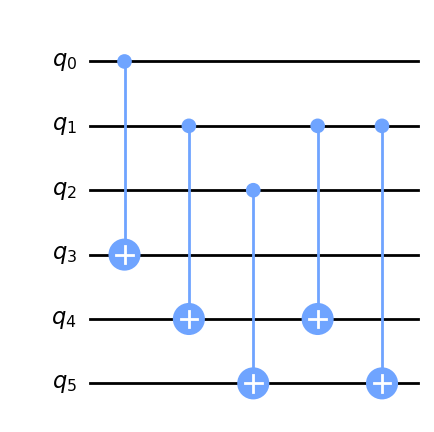

In [4]:
d = build_qf(3, "110")
d.draw('mpl')

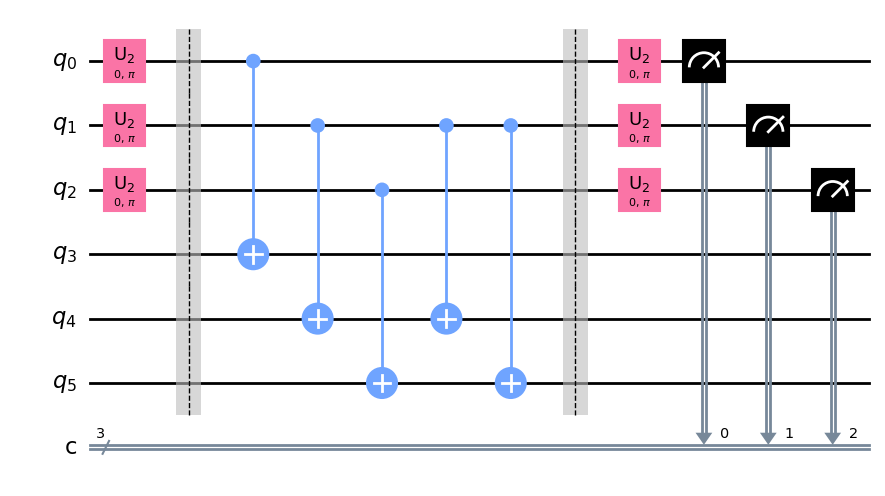

In [5]:
n: int = int(input("n = ... "))
s: str = input("s = ... ")

circuit = QuantumCircuit(2*n,n)
# prepare our initial state - hadamard for first register
circuit.h(range(n))
circuit.barrier()
#Choose an oracle
query = build_qf(n, s).to_instruction()

circuit.append(query, range(2*n))
circuit.barrier()
# Hadamard and measure
#circuit.measure(range(n,2*n), ) # measure second register
circuit.h(range(n)) # hadamard first
circuit.measure(range(n),range(n))
circuit.decompose().draw('mpl')
#circuit.draw('mpl')

### Results

Running the circuit many times, we see the 4 results that occur with 25% probability. 

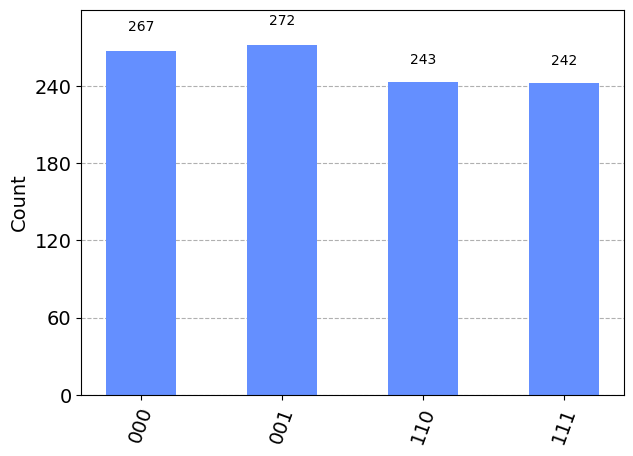

In [6]:
from qiskit.visualization import plot_histogram

backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuit, backend))
counts = job.result().get_counts()
plot_histogram(counts)

In our case we gave $s$ as an input, so we know it:

In [7]:
s

'110'

We can verify that these results satisft $s \cdot z = 0 (\text{mod}~2)$

In [8]:
def dot(s, z) -> int:
    total: int= 0
    for i in range(len(s)):
        total += int(s[i]) * int(z[i])
    return (total % 2)

for z in counts:
    print(f"{z} dot {s} = {dot(z,s)} (mod 2)")


001 dot 110 = 0 (mod 2)
000 dot 110 = 0 (mod 2)
111 dot 110 = 0 (mod 2)
110 dot 110 = 0 (mod 2)


For test case n=3, s = 110:
$$ 
b_2 = 0 (\text{mod~} 2)\\
b_0 + b_1 + b_2 = 0 (\text{mod~} 2)\\
b_0 + b_1 = 0 (\text{mod~} 2)\\$$

so
$$b_2 = 0\\
b_0 + b_1 = 0 (\text{mod~} 2)$$

And we have two options:

$$ s = 000 \\ s = 110$$

Because $s=110 \ne 000$ is a solution, we have shown that the function must be two to one, as expected.

#### Solve for $s$

In [9]:
jr = job.result()
jr.get_counts()


{'001': 272, '000': 267, '111': 242, '110': 243}

In [13]:
a = np.array([[int(i) for i in k] for k in jr.get_counts()])
a

array([[0, 0, 1],
       [0, 0, 0],
       [1, 1, 1],
       [1, 1, 0]])

In [18]:
ss = np.array([1,1,0])
ss

array([1, 1, 0])

In [19]:
np.matmul(a,ss)

array([0, 0, 2, 2])

In [11]:
import scipy as sp

def solve_equations(data,results):
    tolerance = 1e-3
    sing_values = sp.linalg.svdvals(results)
    print(sing_values)
    if sum(sing_values < tolerance) == 0:
        print("Sucess")
    else:
        print(sing_values < tolerance)

In [12]:
solve_equations(None, a)

[2.17532775e+00 1.12603250e+00 1.19381245e-16 0.00000000e+00]
[False False  True  True]


In [22]:
from scipy.linalg import solve
eqs = [k+'0' for k in jr.get_counts()]
eqs

['0010', '0000', '1110', '1100']